## Import modules and load data

In [1]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# We use the Seaborn module to make pretty plots
import seaborn as sns
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics

/Users/michelangelo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data = pd.read_csv("train.csv")

## Explore the loaded data

In [4]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

The goal of this data analysis is to determine the probablity of survival based on the available data. Intuitively, we expect a better treatment for wealthy people, for women and children. 

Let's start our analysis by exploring the onboard population. How many people survived? Were there more man or women? What was the age distribution? Were there more families or more single people?

In [7]:
pd.crosstab(data.Survived, data.Sex)

Sex       female  male
Survived              
0             81   468
1            233   109

We are considering data about 891 passengers, 35% of which were women. The survival rate is sex dependent: only 19% of the women survived, and 74% of the men. 

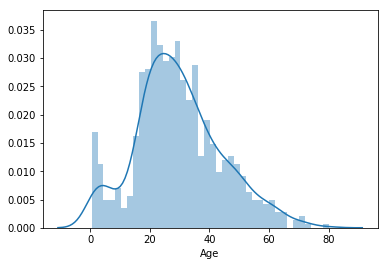

In [8]:
%matplotlib inline
sns.distplot(data.Age[~np.isnan(data.Age)], bins = 40)

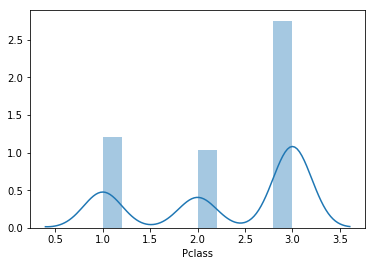

In [9]:
sns.distplot(data.Pclass)

In [10]:
pd.crosstab(data.Survived, data.Pclass)

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Onboard, the median ager was just below 30, and most of the people were travelling in third class. Survivors divided by class: 62% of first class people, 47% of second class and 24% of third class people. In general, for all classes women were younger and were more likely to travel with family than men. 

In [11]:
pd.crosstab(data.Pclass, data.Sex)

Sex     female  male
Pclass              
1           94   122
2           76   108
3          144   347

In [12]:
class_sex_grouping = data.groupby(['Pclass','Sex']).mean()
class_sex_grouping

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

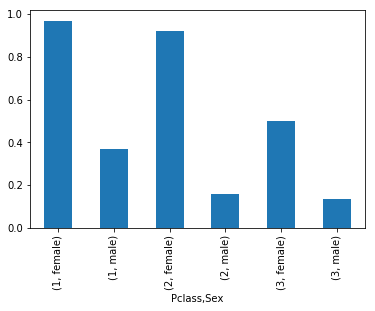

In [13]:
class_sex_grouping['Survived'].plot.bar()

As age seems to be an important attribute, we discard the passengers where no age information is available. The cabin information is relative to only 204 passengers, so we decide not to consider this. 

In [14]:
def preprocess_titanic_data(data):
    processed_data = data.copy()
    le = preprocessing.LabelEncoder()
    processed_data.Sex = le.fit_transform(processed_data.Sex)
    processed_data = processed_data.dropna(subset = ["Age","Embarked"])
    processed_data.Embarked = le.fit_transform(processed_data.Embarked)
    processed_data = processed_data.drop(['Name','Ticket'],axis=1)
    processed_data = processed_data.drop("Cabin", axis = 1)
    return processed_data

Applying the preprocessing function, we 
  
  - Drop the entries where the age and the leaving harbour is not provided
  - Substitute the sex and the leaving harbour attributes with numerical values
  - We drop the ticket and the cabin attribute: they are chars, difficult to manage
  - We have cabin information for only 204 travelers, so we exlude the relative entries

In [15]:
processed_data = preprocess_titanic_data(data)

In [16]:
processed_data.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0            1         0       3    1  22.0      1      0   7.2500         2
1            2         1       1    0  38.0      1      0  71.2833         0
2            3         1       3    0  26.0      0      0   7.9250         2
3            4         1       1    0  35.0      1      0  53.1000         2
4            5         0       3    1  35.0      0      0   8.0500         2

In [17]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Sex            712 non-null int64
Age            712 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Fare           712 non-null float64
Embarked       712 non-null int64
dtypes: float64(2), int64(7)
memory usage: 55.6 KB


Let's further explore the correlations between the variables

In [18]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114771250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1ca0f350>]], dtype=object)

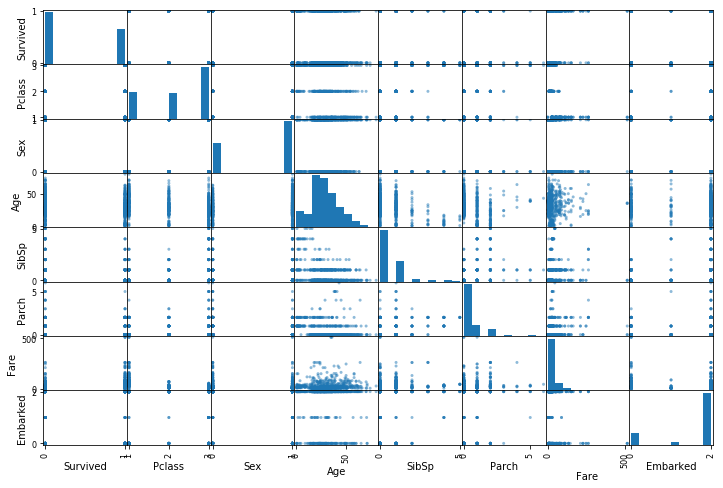

In [19]:
attributes = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
scatter_matrix(processed_data[attributes], figsize = (12,8))

## Select and train a model

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

In [41]:
train_data = processed_data.drop("Survived", axis=1) # drop labels for training set
data_labels = processed_data["Survived"].copy()

### Decision trees and random forests

In [ ]:
tree_cl = DecisionTreeClassifier()
tree_cl.fit(train_data, data_labels)

In [35]:
titanic_prediction = tree_cl.predict(train_data)
tree_mse = mean_squared_error(data_labels, titanic_prediction)

In [37]:
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Wow our model perfeclty fits the data! Or not? Most probably we are overfitting... To fix this, we split the training set in two parts: one for training and one for validation. 

In [49]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_cl, train_data, data_labels, 
                        scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [51]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [52]:
display_scores(tree_rmse_scores)

('Scores:', array([ 0.58925565,  0.52704628,  0.54006172,  0.56519417,  0.53074489,
        0.63910148,  0.44405304,  0.45963856,  0.37796447,  0.41403934]))
('Mean:', 0.50870995963698296)
('Standard deviation:', 0.078185768752370613)


Not so convincing as a result. Most probably we are overfitting the model. Let's try to use a Random Forest approach instead.

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
forest_cl = RandomForestClassifier()

In [66]:
forest_cl.fit(train_data, data_labels)
forest_predict = forest_cl.predict(train_data)

In [68]:
forest_mse = mean_squared_error(data_labels, forest_predict)
forest_rmse = np.sqrt(forest_mse)

In [69]:
forest_rmse

0.105999788000636

In [71]:
forest_scores = cross_val_score(forest_cl, train_data, data_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

('Scores:', array([ 0.45643546,  0.54006172,  0.48591266,  0.47140452,  0.42790021,
        0.48932261,  0.39361095,  0.48932261,  0.37796447,  0.41403934]))
('Mean:', 0.45459745619904862)
('Standard deviation:', 0.047887351402319103)


### Fine tuning

In [72]:
from sklearn.model_selection import GridSearchCV

In [81]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30, 40, 50, 60, 100, 1000], 'max_features': [1, 2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_cl, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(train_data, data_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30, 40, 50, 60, 100, 1000], 'max_features': [1, 2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [82]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [83]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

(0.51929078688949859, {'max_features': 1, 'n_estimators': 3})
(0.46657971367546958, {'max_features': 1, 'n_estimators': 10})
(0.48430420377873329, {'max_features': 1, 'n_estimators': 30})
(0.48430420377873329, {'max_features': 1, 'n_estimators': 40})
(0.47699904600286197, {'max_features': 1, 'n_estimators': 50})
(0.48139544351157693, {'max_features': 1, 'n_estimators': 60})
(0.4740454631399772, {'max_features': 1, 'n_estimators': 100})
(0.47256174913081256, {'max_features': 1, 'n_estimators': 1000})
(0.51793670169847217, {'max_features': 2, 'n_estimators': 3})
(0.48139544351157693, {'max_features': 2, 'n_estimators': 10})
(0.45437943852831125, {'max_features': 2, 'n_estimators': 30})
(0.46808238975153255, {'max_features': 2, 'n_estimators': 40})
(0.47699904600286197, {'max_features': 2, 'n_estimators': 50})
(0.47107336197194438, {'max_features': 2, 'n_estimators': 60})
(0.46507218238834785, {'max_features': 2, 'n_estimators': 100})
(0.47107336197194438, {'max_features': 2, 'n_estimator

In [84]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([ 0.19807452,  0.08808986,  0.23075367,  0.19606189,  0.03757897,
        0.03790264,  0.18278789,  0.02875056])

From which we have that the two most important estimators are sex and age

### Consideration of test values

In [88]:
test_data = pd.read_csv("test.csv")

In [91]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [98]:
final_model = grid_search.best_estimator_

test_data_prepared = preprocess_titanic_data(test_data)

In [111]:
test_data_prepared.head()

PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0          892       3    1  34.5      0      0   7.8292         1
1          893       3    0  47.0      1      0   7.0000         2
2          894       2    1  62.0      0      0   9.6875         1
3          895       3    1  27.0      0      0   8.6625         2
4          896       3    0  22.0      1      1  12.2875         2

In [113]:
test_data_prepared = test_data_prepared.dropna(subset = ["Fare"])
final_predictions = final_model.predict(test_data_prepared)

In [110]:
final_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0,